## Setup

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

SEED = 1234
tf.random.set_seed(SEED)
np.random.seed(SEED)

cwd = os.getcwd()
drive_path = os.path.join(cwd, 'drive')
my_drive_path = os.path.join(drive_path, 'My Drive')

project_path = os.path.join(my_drive_path, 'AN2DL-Project')
data_path = os.path.join(project_path, 'data')
train_path = os.path.join(data_path, 'Training')
test_path = os.path.join(data_path, 'Test_Dev')
logs_path = os.path.join(project_path, 'logs')
results_path = os.path.join(project_path, 'results')

X_dir = 'Images'
Y_dir = 'Masks'

teams = ['Bipbip','Pead','Roseau','Weedelec']
crops = ['Haricot','Mais']

train_imgs_path = os.path.join(train_path, 'training.txt')
valid_imgs_path = os.path.join(train_path, 'validation.txt')

In [2]:
from google.colab import drive
drive.mount(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Preprocessing

In [4]:
# Splitting all data in train/valid on random teams and crops

train_imgs_stream = open(train_imgs_path, 'w')
valid_imgs_stream = open(valid_imgs_path, 'w')

for team in teams:
  for crop in crops:
    curr_imgs = []

    for root,dirs,files in os.walk(os.path.join(train_path, team, crop, X_dir)):
      print("Found {} images for team {}, crop {}".format(len(files),team,crop))
      for file in files:
        curr_imgs.append(os.path.splitext(file)[0])

    np.random.shuffle(curr_imgs)
    curr_valid = curr_imgs[:18]
    curr_train = curr_imgs[18:]

    for t in curr_train:
      train_imgs_stream.write("{} {} {}\n".format(team, crop, t))
    for v in curr_valid:
      valid_imgs_stream.write("{} {} {}\n".format(team, crop, v))

train_imgs_stream.close()
valid_imgs_stream.close()

Found 90 images for team Bipbip, crop Haricot
Found 90 images for team Bipbip, crop Mais
Found 90 images for team Pead, crop Haricot
Found 90 images for team Pead, crop Mais
Found 90 images for team Roseau, crop Haricot
Found 90 images for team Roseau, crop Mais
Found 90 images for team Weedelec, crop Haricot
Found 90 images for team Weedelec, crop Mais


In [5]:
img_h = 299
img_w = 299

num_channels = 3
num_classes = 4

batch_size = 10

def rgb_to_target_mask(mask_rgb):
    mask_arr = np.array(mask_rgb)

    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    new_mask_arr[np.where(np.all(mask_arr == [216, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2

    return new_mask_arr

def target_to_rgb_mask(mask_arr):
    mask_arr = np.array(mask_arr)

    new_mask_rgb = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    new_mask_rgb[np.where(np.all(mask_arr == 0, axis=-1))] = [216, 124, 18]
    new_mask_rgb[np.where(np.all(mask_arr == 1, axis=-1))] = [255, 255, 255]
    new_mask_rgb[np.where(np.all(mask_arr == 2, axis=-1))] = [216, 67, 82]

    return new_mask_rgb

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=3,
                                      height_shift_range=3,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
mask_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=3,
                                      height_shift_range=3,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')

In [7]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self, out_shape, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None):
    self.out_shape = out_shape
    
    if which_subset == 'training':
      subset_file = train_imgs_path
    elif which_subset == 'validation':
      subset_file = valid_imgs_path
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_data = []
    for line in lines:
      subset_data.append(line.strip()) 

    self.which_subset = which_subset
    self.subset_data = subset_data
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_data)

  def __getitem__(self, index):
    print("1")
    team, crop, name = self.subset_data[index].split()
    img = Image.open(os.path.join(train_path, team, crop, X_dir, name + '.jpg'))
    mask = Image.open(os.path.join(train_path, team, crop, Y_dir, name + '.png'))
    print("2")

    img = img.resize(self.out_shape)
    mask = mask.resize(self.out_shape, resample=Image.NEAREST)
    print("3")
    mask = mask.convert("P")
    img_arr = np.array(img)
    mask_arr = np.array(mask)

    mask_arr = np.expand_dims(mask_arr, -1)
    print("4")

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            curr_class_arr = np.uint8(curr_class_arr)
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    print("5")
    if self.preprocessing_function is not None:
      img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [9]:
from tensorflow.keras.applications.vgg16 import preprocess_input 

training_dataset = CustomDataset((img_h,img_w), 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen,
                        preprocessing_function=preprocess_input)
validation_dataset = CustomDataset((img_h,img_w), 'validation', 
                              preprocessing_function=preprocess_input)

print("Found {} images for training".format(len(training_dataset)))
print("Found {} images for validation".format(len(validation_dataset)))

Found 576 images for training
Found 144 images for validation


In [10]:
train_dataset = tf.data.Dataset.from_generator(lambda: training_dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, num_channels],
                                                              [img_h, img_w, 1]))
train_dataset = train_dataset.batch(16)
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: validation_dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, num_channels],
                                                              [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(16)
valid_dataset = valid_dataset.repeat()

print(train_dataset)
print(valid_dataset)

<RepeatDataset shapes: ((None, 299, 299, 3), (None, 299, 299, 1)), types: (tf.float32, tf.float32)>
<RepeatDataset shapes: ((None, 299, 299, 3), (None, 299, 299, 1)), types: (tf.float32, tf.float32)>


In [ ]:
iterator = iter(train_dataset)
img, target = next(iterator)
#print(img)
#print(target)

1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
1
2
3
4
5
[  0. 225.]


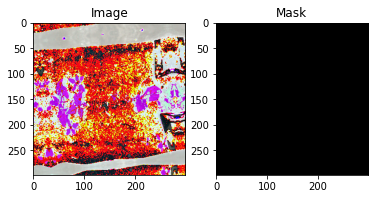

In [11]:
from matplotlib import cm

colors = [cm.rainbow(x) for x in np.linspace(0, 1, 4)]
iterator = iter(train_dataset)

fig, ax = plt.subplots(1, 2)

img, target = next(iterator)
img = img[0]
img = img

target = np.array(target[0, ..., 0])
print(np.unique(target))

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(1, 5):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(img))
ax[0].set_title("Image")
ax[1].imshow(np.uint8(target_img))
ax[1].set_title("Mask")

plt.show()

## Model

In [ ]:
# Encoder

finetuning=True
freeze_until=15

basic_model = tf.keras.applications.VGG16(weights='imagenet',
                                          include_top=False, 
                                          input_shape=(img_h, img_w, num_channels))

if finetuning:
  for layer in basic_model.layers[:freeze_until]:
    layer.trainable = False
else:
  basic_model.trainable = False

#basic_model.summary()

In [ ]:
model = tf.keras.Sequential()
model.add(basic_model)

# Decoder

for i in range(depth):
  model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
  model.add(tf.keras.layers.Conv2D(filters=start_f,
                                    kernel_size=(3, 3),
                                    strides=(1, 1),
                                    padding='same'))
  model.add(tf.keras.layers.ReLU())
  start_f = start_f // 2

model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                  kernel_size=(1, 1),
                                  strides=(1, 1),
                                  padding='same',
                                  activation='softmax'))

model.summary()

## Learning

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/AN2DL-Project/logs

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

def meanIoU(y_true, y_pred):
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)
    per_class_iou = []

    for i in range(2,4): # exclude the background class 0
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)
      
    return tf.reduce_mean(per_class_iou)

metrics = ['accuracy', meanIoU]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
from datetime import datetime

model_name = 'Solution_V1.0'
now = datetime.now().strftime('%b%d_%H-%M-%S')
exp_dir = os.path.join(logs_path, model_name + '_' + str(now))

In [ ]:
import os
    
callbacks = []

ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 
                                                                        'cp_{epoch:02d}.ckpt'),           
                                                    save_weights_only=True,
                                                    save_best_only=True)
callbacks.append(ckpt_callback)

tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)
callbacks.append(tb_callback)

early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)
    callbacks.append(es_callback)

model.fit(x=train_dataset,
          epochs=100,
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen), 
          callbacks=callbacks)

## Test predictions

In [ ]:
ckpt_file = input('Enter checkpoint file name: ')

In [ ]:
from PIL import Image

model_path = os.path.join(ckpt_dir, ckpt_file)
model.load_weights(model_path)

image_filenames = next(os.walk(test_path))[2]

results = {}
for image_name in image_filenames:
    img = Image.open(test_path + '/' + image_name).convert('RGB')
    img = img.resize((img_w, img_h))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, 0)
    img_array = img_array * 1./255
    prediction = model.predict(img_array, batch_size=1)
    c = np.argmax(prediction)
    results[image_name] = c

csv_fname = model_name
csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

with open(os.path.join(results_path, csv_fname), 'w') as f:
  f.write('Id,Category\n')

  for key, value in results.items():
    f.write(key + ',' + str(value) + '\n')

print('Saved {}'.format(csv_fname))